In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("online_gaming_behavior_dataset.csv")

## Exploratory Data Analysis (EDA)

In [7]:
print(df.head())

# General Information
print(df.info())

   PlayerID  Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0      9000   43    Male    Other  Strategy      16.271119                0   
1      9001   29  Female      USA  Strategy       5.525961                0   
2      9002   22  Female      USA    Sports       8.223755                0   
3      9003   35    Male      USA    Action       5.265351                1   
4      9004   33    Male   Europe    Action      15.531945                0   

  GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0         Medium                6                        108           79   
1         Medium                5                        144           11   
2           Easy               16                        142           35   
3           Easy                9                         85           57   
4         Medium                2                        131           95   

   AchievementsUnlocked EngagementLevel  
0                   

In [8]:
# Check missing values
print(df.isnull().sum())

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64


In [10]:
# Kategorik sütunların benzersiz değerleri
for col in df.select_dtypes(include='object').columns:
    print(f"{col}: {df[col].unique()}")


Gender: ['Male' 'Female']
Location: ['Other' 'USA' 'Europe' 'Asia']
GameGenre: ['Strategy' 'Sports' 'Action' 'RPG' 'Simulation']
GameDifficulty: ['Medium' 'Easy' 'Hard']
EngagementLevel: ['Medium' 'High' 'Low']


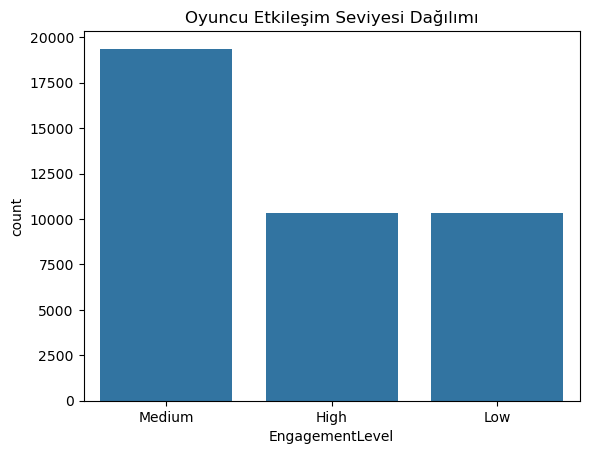

In [11]:
# Hedef değişkenin dağılımı
sns.countplot(x='EngagementLevel', data=df)
plt.title("Oyuncu Etkileşim Seviyesi Dağılımı")
plt.show()


1. Demografik Analiz

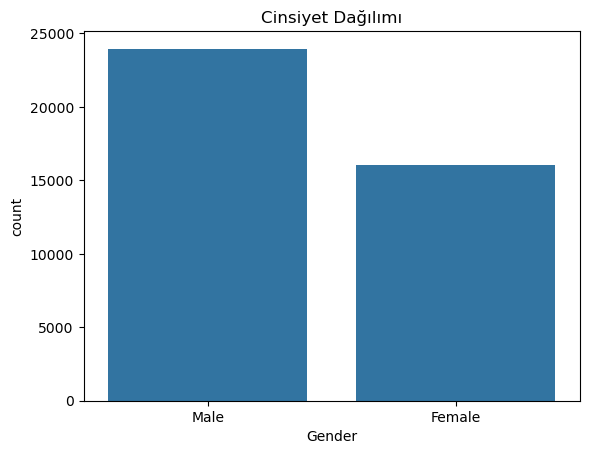

In [12]:
# Cinsiyet dağılımı

sns.countplot(x='Gender', data=df)
plt.title("Cinsiyet Dağılımı")
plt.show()

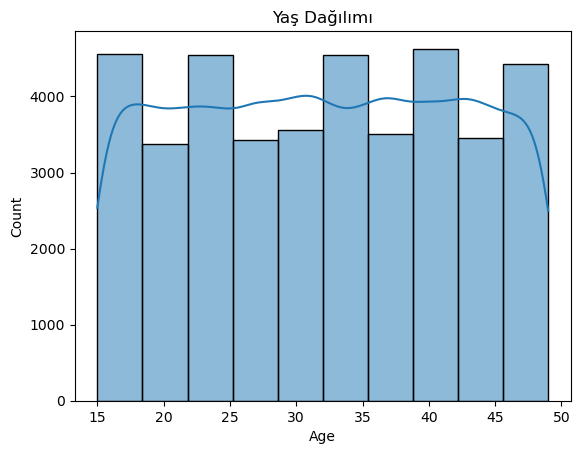

In [13]:
# Yaş dağılımı
sns.histplot(df['Age'], bins=10, kde=True)
plt.title("Yaş Dağılımı")
plt.show()

2. Oyun Süresi ve Seanslar

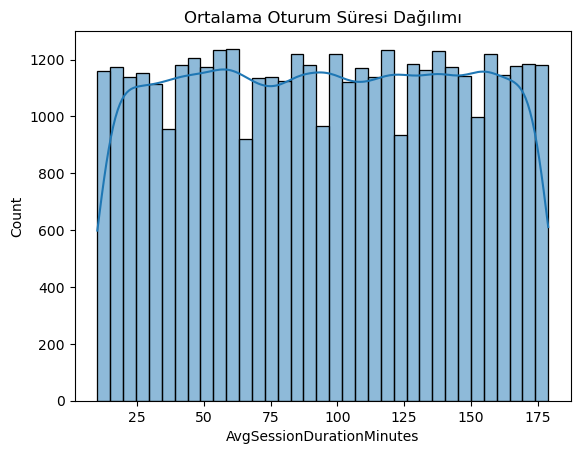

In [15]:
# Ortalama oturum süresi
sns.histplot(df['AvgSessionDurationMinutes'], kde=True)
plt.title("Ortalama Oturum Süresi Dağılımı")
plt.show()


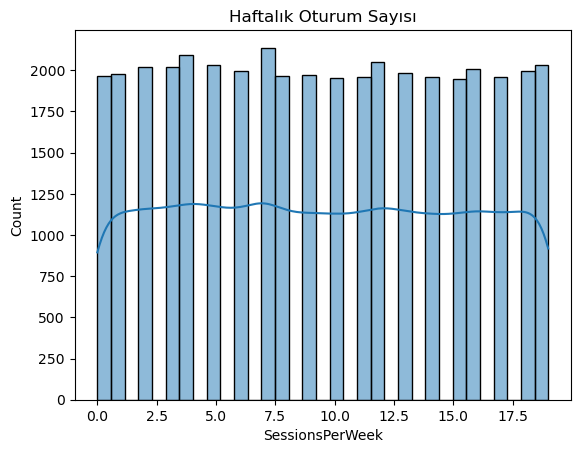

In [16]:
# Haftalık seans sayısı
sns.histplot(df['SessionsPerWeek'], kde=True)
plt.title("Haftalık Oturum Sayısı")
plt.show()

## Makine Öğrenmesi ile Davranış Tahmini

1. Veriyi Hazırlama

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score


# Kategorik değişkenleri sayısallaştır
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# Hedef değişken: Engagement Level
X = df.drop(columns=['EngagementLevel'])
y = df['EngagementLevel']

# Eğitim ve test veri seti
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


2. Model Eğitimi (Random Forest)

In [27]:
# Kategorik sütünların tespiti

categorical_cols = df.select_dtypes(include='object').columns
print("Kategorik sütunlar:", categorical_cols)


Kategorik sütunlar: Index(['Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel'], dtype='object')


In [28]:
#  One-Hot Encoding => Tüm kategorik sütunları 0-1 şeklinde sayısallaştırır.

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [29]:
print(df_encoded.columns.tolist())

['PlayerID', 'Age', 'Gender', 'PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'Location_Europe', 'Location_Other', 'Location_USA', 'GameGenre_RPG', 'GameGenre_Simulation', 'GameGenre_Sports', 'GameGenre_Strategy', 'GameDifficulty_Hard', 'GameDifficulty_Medium', 'EngagementLevel_Low', 'EngagementLevel_Medium']


In [30]:
# 3. EngagementLevel sütununu yeniden oluştur
def get_engagement_level(row):
    if row['EngagementLevel_Low'] == 1:
        return 'Low'
    elif row['EngagementLevel_Medium'] == 1:
        return 'Medium'
    else:
        return 'High'  # drop_first=True olduğu için bu sınıf encoding dışı kalmış

df_encoded['EngagementLevel'] = df_encoded.apply(get_engagement_level, axis=1)

# 4. Hedef değişkeni LabelEncoder ile dönüştür
le = LabelEncoder()
y = le.fit_transform(df_encoded['EngagementLevel'])

# 5. Özellikleri (X) seç — ID ve hedef sütunları çıkar
X = df_encoded.drop(columns=['PlayerID', 'EngagementLevel', 'EngagementLevel_Low', 'EngagementLevel_Medium'])

# 6. Eğitim/test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Modeli tanımla ve eğit
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 8. Tahmin yap ve sonuçları değerlendir
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.9042088172848758

Classification Report:
               precision    recall  f1-score   support

        High       0.92      0.86      0.89      2035
         Low       0.91      0.87      0.89      2093
      Medium       0.90      0.94      0.92      3879

    accuracy                           0.90      8007
   macro avg       0.91      0.89      0.90      8007
weighted avg       0.90      0.90      0.90      8007



## Oyuncu Segmentasyonu 

1. Davranış Temelli Segmentasyon (KMeans)

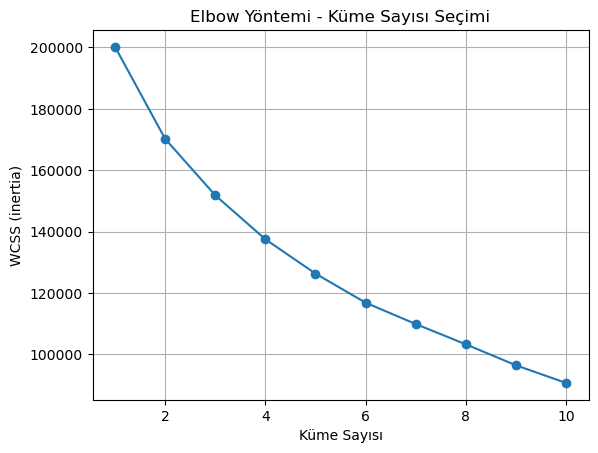

''

In [31]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Segmentasyonda kullanılacak davranışsal özellikler
behavior_features = ['PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes',
                     'PlayerLevel', 'AchievementsUnlocked']

# 2. Bu özelliklerin ölçeklendirilmesi
scaler = StandardScaler()
X_behavior = scaler.fit_transform(df[behavior_features])

# 3. En uygun küme sayısını bulmak için Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_behavior)
    wcss.append(kmeans.inertia_)

# Elbow grafiği çizimi
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS (inertia)')
plt.title('Elbow Yöntemi - Küme Sayısı Seçimi')
plt.grid(True)
plt.show()
;

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [33]:
# CSV'den veriyi oku
df = pd.read_csv("online_gaming_behavior_dataset.csv")

# Segmentasyonda kullanılacak sayısal sütunları seç
features = ['PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
            'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']

X = df[features]

# Ölçekleme (Standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [34]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['Segment'] = kmeans.fit_predict(X_scaled)


In [35]:
# Her segmentin ortalama istatistikleri
segment_summary = df.groupby('Segment')[features].mean()
print(segment_summary)


         PlayTimeHours  InGamePurchases  SessionsPerWeek  \
Segment                                                    
0            11.945697         0.194707         9.040929   
1            11.784897         0.185129         4.069323   
2            12.377212         0.200512         9.817206   
3            11.982929         0.223598        15.055567   

         AvgSessionDurationMinutes  PlayerLevel  AchievementsUnlocked  
Segment                                                                
0                        96.152007    26.890791             10.747540  
1                        95.036925    73.428313             25.522387  
2                        92.162614    26.582045             37.955803  
3                        95.862874    73.141834             23.884056  


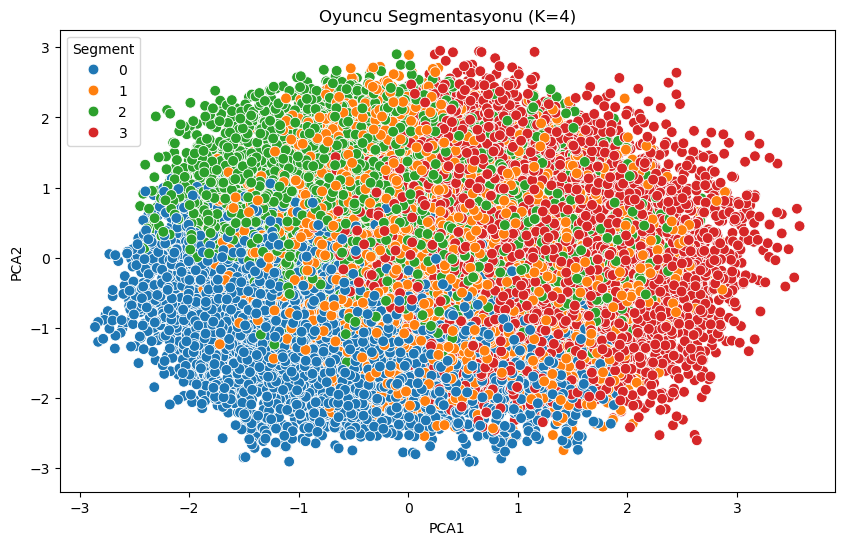

In [36]:
from sklearn.decomposition import PCA

# PCA ile 2 boyuta indirmek için
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]

# Segmentleri çiz
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Segment', palette='tab10', data=df, s=60)
plt.title('Oyuncu Segmentasyonu (K=4)')
plt.show()


PCA1 ve PCA2 eksenlerinde segmentler arasında gözle görülür bir ayrışma var. Bu, KMeans algoritmasının anlamlı kümeler oluşturduğunu gösterir.

Kümelerin Dağılımı:

Segment 0 (Mavi): Sol-alt bölgede yoğunlaşmış. Bu grup PCA uzayında belirgin olarak ayrılmış.

Segment 1 (Turuncu): Mavi ve kırmızı segmentler arasında bir geçiş grubu gibi duruyor.

Segment 2 (Yeşil): Üst-orta bölgede kümelenmiş. Bu grup da göreceli olarak ayrışmış.

Segment 3 (Kırmızı): Sağ ve üst sağ bölgede çok yaygın bir dağılıma sahip. Bu segmentin dağılımı daha geniş, daha heterojen olabilir.

Karışan Alanlar:
Turuncu (1) ve yeşil (2) segmentlerde mavi (0) ve kırmızı (3) ile kısmi karışmalar görülüyor. Bu da bu segmentlerin bazı ortak özellikler taşıyabileceğini gösterir.

In [37]:
# Segment bazında ortalamalar
features = ['PlayTimeHours', 'InGamePurchases', 'SessionsPerWeek',
            'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']
segment_summary = df.groupby('Segment')[features].mean()
print(segment_summary)


         PlayTimeHours  InGamePurchases  SessionsPerWeek  \
Segment                                                    
0            11.945697         0.194707         9.040929   
1            11.784897         0.185129         4.069323   
2            12.377212         0.200512         9.817206   
3            11.982929         0.223598        15.055567   

         AvgSessionDurationMinutes  PlayerLevel  AchievementsUnlocked  
Segment                                                                
0                        96.152007    26.890791             10.747540  
1                        95.036925    73.428313             25.522387  
2                        92.162614    26.582045             37.955803  
3                        95.862874    73.141834             23.884056  


2. Monetization Temelli Segmentasyon

In [38]:
# Monetization için kullanılacak öznitelikler
monetization_features = ['InGamePurchases', 'PlayTimeHours', 'AvgSessionDurationMinutes', 'PlayerLevel', 'SessionsPerWeek']

# Bu özelliklerle veri çerçevesi oluştur
df_monetization = df[monetization_features].copy()

In [39]:
scaler = StandardScaler()
monetization_scaled = scaler.fit_transform(df_monetization)

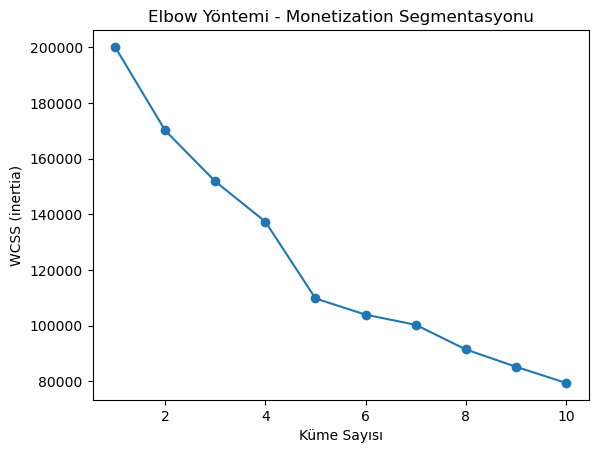

In [40]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(monetization_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Yöntemi - Monetization Segmentasyonu')
plt.xlabel('Küme Sayısı')
plt.ylabel('WCSS (inertia)')
plt.show()


In [41]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['MonetizationSegment'] = kmeans.fit_predict(monetization_scaled)


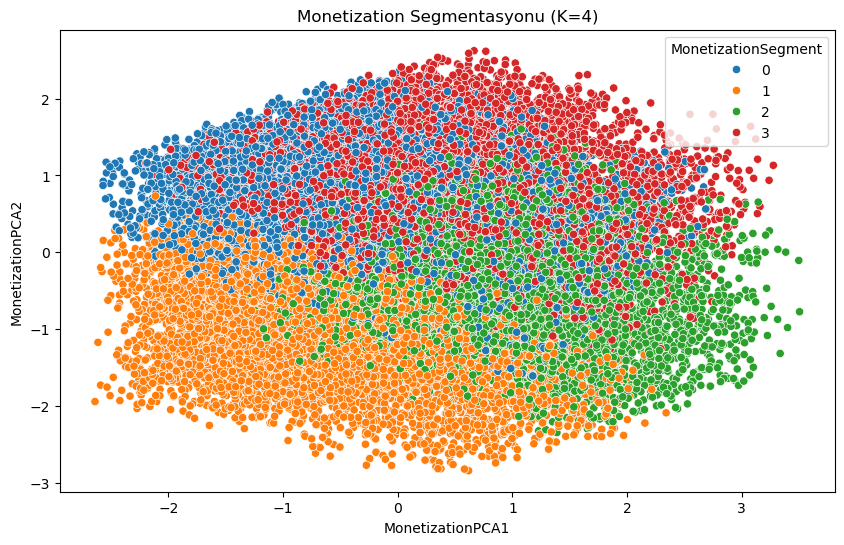

In [42]:
pca = PCA(n_components=2)
components = pca.fit_transform(monetization_scaled)

df['MonetizationPCA1'] = components[:, 0]
df['MonetizationPCA2'] = components[:, 1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='MonetizationPCA1', y='MonetizationPCA2', hue='MonetizationSegment', palette='tab10')
plt.title('Monetization Segmentasyonu (K=4)')
plt.show()


In [43]:
df.groupby('MonetizationSegment')[monetization_features].mean()


,InGamePurchases,PlayTimeHours,AvgSessionDurationMinutes,PlayerLevel,SessionsPerWeek
MonetizationSegment,,,,,
0,0.202138,9.735681,133.736332,23.562840,9.697902
1,0.197003,18.419618,56.515875,40.854467,9.424177
2,0.200724,5.717375,55.245251,58.453513,9.505176
3,0.203610,14.076176,134.233922,75.621597,9.263237


0 → Big Spenders

1 → Casual Buyers

2 → Free Players

3 → Light Users